A notebook for processing calibration data for the cameras of the OROCHI Simualtor of the Kameda Lab.

Processing of data captured on 22/05/2023 - repeated at 12-bit resolution.

# Process Overview

The objective of this notebook is to process uniformly illuminated and dark images (across the sampling area) and characterise each camera of the OROCHI simulator, in terms of:
- Linearity
- Read Noise
- Gain
- FPN
- Dark Signal

The goal is to validate the linearity, full-well and read-noise of the cameras,and establish the range of the camera response we need to operate in order to match the signal-to-noise ratio expected of the OROCHI Flight Model.

To do this, we will process images of the 99% Reflectance Spectralon Calibration Target (SCT99) and the 5% Reflectance Spectral Calibration Target (SCT5), and images without illumination, at exposures that range from the minimum possible with the cameras (~5 µs) up to a maximum, defined such that all pixels of the image are saturated (DN=255).

For each of the SCT99 and SCT5 targets, we:
- for each channel:
    - load the list of exposures
    - for each exposure,
        - load image 1
        - load image 2
        - load the dark frame
        - get mean of image 1 - dark
        - get the noise of image 1 - dark
        - get the noise of image 1 - image 2
    - get the read noise
    - get shot noise
    - get sensitivity
    - get full well
    - evaluate linearity
    - plot mean vs exposure
    - plot noise vs mean
    - plot fpn-removed noise vs mean
    - plot shot noise vs mean
    - plot sensitivity vs mean

For each of these, we will also plot the expected data, based on the datasheet of the OROCHI simulator (Oro-S), and the expected performance of the OROCHI Flight Model (Oro-M).

Here, we run preliminary analysis, and investigate if further adjustments to the experimental procedure are needed.

As we'd like to repeat this for each camera, we will write each of these steps into functions, contained in the notebook here, such that the analysis can be iterated and automated.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# PCT99

Here we process the PTC (Photon Transfer Curve) data for each channel in turn.


In [6]:
from pathlib import Path
import orochi_sim_proc as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def process_ptc(subject: str):
    channels = sorted(list(Path('..', 'data', subject).glob('[!.]*')))

    # grouped plots
    fig_k, ax_k = plt.subplots() # init the grouped k_adc plot
    fig_snr, ax_snr = plt.subplots() # init the grouped snr plot
    fig_e, ax_e = plt.subplots() # init the grouped electron plot
    fig_d, ax_d = plt.subplots() # init the grouped dark noise plot

    fw_exp_os = 32059.0 # expected full well (e-) for Oro-S
    fw_exp_of = 20000.0 # expected full well (e-) for Oro-S
    rn_exp_os = 7.07 # expected read noise (e-) for Oro-S
    k_exp_of = fw_exp_of / 2**12 # expected sensitivity in 12-bit mode for Oro-M
    k_exp_os = 7.979 # expected sensitivity in 12-bit mode for Oro-S - Baumer EMVA Study
    snr_exp_of = fw_exp_of / np.sqrt(fw_exp_of) # expected peak SNR for Oro-M
    snr_exp_os = fw_exp_os / np.sqrt(fw_exp_os) # expected peak SNR for Oro-S
    snr_min = 100 # minimum acceptable SNR

    fig_exp, ax_exp = osp.grid_plot() # init the exposure grid plot
    fig_ptc, ax_ptc = osp.grid_plot() # init the exposure grid plot

    k_adcs = []
    full_wells = []
    read_noises = []
    drs = []

    for channel_path in channels:
        channel = channel_path.name
        print('--------------------------------------------')
        print(f'Processing {subject}/{channel}')
        # load the calibration target images, and compute the full well, linear sensitivity and read noise
        pct_data, full_well, k_adc, read_noise = osp.load_pct_frames(subject, channel)
        # pct_data.sort_values('exposure', inplace=True)

        # plot sensitivity for all channels
        ax_k.plot(pct_data['mean'], pct_data['k_adc'], 'o', label=channel)    
        colour = ax_k.get_lines()[-1].get_color() # get colour for channel
        # overplot the mean k_adc for the channel
        ax_k.plot(pct_data['mean'], k_adc+(0.0*pct_data['mean']), color=colour)    
        ax_k.set_ylim(0, 2.0 * k_exp_os)    

        # plot Mean vs Exposure
        # get camera number
        num = int(channel.split('_')[0])
        pct_data.plot.scatter('exposure', 'mean', title=channel, color=colour, logx=True, logy=True, ax=ax_exp[num])

        # plot mean dark noise vs mean
        pct_data.plot.scatter('exposure', 'd_std_t', label=channel, color=colour, ax=ax_d, logx=True)

        # plot Noise (Total, FPN-removed, Shot) vs Mean
        pct_data.plot('mean', ['std_t', 'std_rs', 'std_s'], marker='o',logx=True, logy=True, title=channel, ax=ax_ptc[num])     

        # plot SNR vs Mean for all channels
        pct_data.plot.scatter('mean','snr', ylim=(0, 200), color=colour, ax=ax_snr, label=channel)     

        # plot electron vs electron noise for all channels
        fw_str = f'{channel} FW: {full_well*k_adc:.2f} e-, RN: {k_adc*read_noise:.2f} e-'
        pct_data.plot.scatter('e-','e-_noise', logx=True, logy=True, label=fw_str, color=colour, ax=ax_e)         
        # add extracted full well, gain and read-noise to the plots

        k_adcs.append(k_adc)
        full_wells.append(full_well*k_adc)
        read_noises.append(read_noise*k_adc)
        drs.append(20.0*np.log10(full_well/read_noise))
        print('--------------------------------------------')
        # print electron full well
    # show legend
    ax_k.plot(pct_data['mean'], k_exp_os+(0.0*pct_data['mean']), label='Oro-S exp.')
    ax_k.plot(pct_data['mean'], k_exp_of+(0.0*pct_data['mean']), label='Oro-F exp.')
    ax_k.legend()
    fig_k.show()
    ax_snr.plot(pct_data['mean'], snr_exp_os+(0.0*pct_data['mean']), label='Oro-S exp.')
    ax_snr.plot(pct_data['mean'], snr_exp_of+(0.0*pct_data['mean']), label='Oro-F exp.')
    ax_snr.plot(pct_data['mean'], snr_min+(0.0*pct_data['mean']), label='Min. accept.')
    ax_snr.legend()
    fig_snr.show()
    # add Oro-M and Oro-S expected full well, gain and read-noise to the plots
    ax_e.legend()
    fig_e.show()
    # ax_d.set_ylim(0.0, 0.5)
    ax_d.legend()
    fig_d.show()
    osp.show_grid(fig_exp, ax_exp)
    osp.show_grid(fig_ptc, ax_ptc)

    results = pd.DataFrame({'channel': channels, 'k_adc': k_adcs, 'full_well': full_wells, 'read_noise': read_noises, 'DR': drs})
    print(results)

--------------------------------------------
Processing SCT99/0_650
Loaded images (650_104us_1_calibration) for: 0 (650 nm)
Loaded images (650_104us_2_calibration) for: 0 (650 nm)
Loaded images (650_104us_d_drk) for: 0 (650 nm)
Loaded images (650_1109us_1_calibration) for: 0 (650 nm)
Loaded images (650_1109us_2_calibration) for: 0 (650 nm)
Loaded images (650_1109us_d_drk) for: 0 (650 nm)
Loaded images (650_124us_1_calibration) for: 0 (650 nm)
Loaded images (650_124us_2_calibration) for: 0 (650 nm)
Loaded images (650_124us_d_drk) for: 0 (650 nm)
Loaded images (650_1331us_1_calibration) for: 0 (650 nm)
Loaded images (650_1331us_2_calibration) for: 0 (650 nm)
Loaded images (650_1331us_d_drk) for: 0 (650 nm)
Loaded images (650_149us_1_calibration) for: 0 (650 nm)
Loaded images (650_149us_2_calibration) for: 0 (650 nm)
Loaded images (650_149us_d_drk) for: 0 (650 nm)
Loaded images (650_1597us_1_calibration) for: 0 (650 nm)
Loaded images (650_1597us_2_calibration) for: 0 (650 nm)
Loaded image

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Loaded images (475_11079us_1_calibration) for: 1 (475 nm)
Loaded images (475_11079us_2_calibration) for: 1 (475 nm)
Loaded images (475_11079us_d_drk) for: 1 (475 nm)
Loaded images (475_1109us_1_calibration) for: 1 (475 nm)
Loaded images (475_1109us_2_calibration) for: 1 (475 nm)
Loaded images (475_1109us_d_drk) for: 1 (475 nm)
Loaded images (475_11191us_1_calibration) for: 1 (475 nm)
Loaded images (475_11191us_2_calibration) for: 1 (475 nm)
Loaded images (475_11191us_d_drk) for: 1 (475 nm)
Loaded images (475_11304us_1_calibration) for: 1 (475 nm)
Loaded images (475_11304us_2_calibration) for: 1 (475 nm)
Loaded images (475_11304us_d_drk) for: 1 (475 nm)
Loaded images (475_11418us_1_calibration) for: 1 (475 nm)
Loaded images (475_11418us_2_calibration) for: 1 (475 nm)
Loaded images (475_11418us_d_drk) for: 1 (475 nm)
Loaded images (475_11533us_1_calibration) for: 1 (475 nm)
Loaded images (475_11533us_2_calibration) for: 1 (475 nm)
Loaded images (475_11533us_d_drk) for: 1 (475 nm)
Loaded 

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/minic

Loaded images (400_53205us_d_drk) for: 3 (400 nm)
Loaded images (400_535us_1_calibration) for: 3 (400 nm)
Loaded images (400_535us_2_calibration) for: 3 (400 nm)
Loaded images (400_535us_d_drk) for: 3 (400 nm)
Loaded images (400_53742us_1_calibration) for: 3 (400 nm)
Loaded images (400_53742us_2_calibration) for: 3 (400 nm)
Loaded images (400_53742us_d_drk) for: 3 (400 nm)
Loaded images (400_54285us_1_calibration) for: 3 (400 nm)
Loaded images (400_54285us_2_calibration) for: 3 (400 nm)
Loaded images (400_54285us_d_drk) for: 3 (400 nm)
Loaded images (400_54833us_1_calibration) for: 3 (400 nm)
Loaded images (400_54833us_2_calibration) for: 3 (400 nm)
Loaded images (400_54833us_d_drk) for: 3 (400 nm)
Loaded images (400_55387us_1_calibration) for: 3 (400 nm)
Loaded images (400_55387us_2_calibration) for: 3 (400 nm)
Loaded images (400_55387us_d_drk) for: 3 (400 nm)
Loaded images (400_55946us_1_calibration) for: 3 (400 nm)
Loaded images (400_55946us_2_calibration) for: 3 (400 nm)
Loaded ima

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/var/folders/w4/44k32f413dd8

--------------------------------------------
--------------------------------------------
Processing SCT99/5_850
Loaded images (850_104us_1_calibration) for: 5 (850 nm)
Loaded images (850_104us_2_calibration) for: 5 (850 nm)
Loaded images (850_104us_d_drk) for: 5 (850 nm)
Loaded images (850_1109us_1_calibration) for: 5 (850 nm)
Loaded images (850_1109us_2_calibration) for: 5 (850 nm)
Loaded images (850_1109us_d_drk) for: 5 (850 nm)
Loaded images (850_11869us_1_calibration) for: 5 (850 nm)
Loaded images (850_11869us_2_calibration) for: 5 (850 nm)
Loaded images (850_11869us_d_drk) for: 5 (850 nm)
Loaded images (850_124us_1_calibration) for: 5 (850 nm)
Loaded images (850_124us_2_calibration) for: 5 (850 nm)
Loaded images (850_124us_d_drk) for: 5 (850 nm)
Loaded images (850_1331us_1_calibration) for: 5 (850 nm)
Loaded images (850_1331us_2_calibration) for: 5 (850 nm)
Loaded images (850_1331us_d_drk) for: 5 (850 nm)
Loaded images (850_14243us_1_calibration) for: 5 (850 nm)
Loaded images (85

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: Ma

--------------------------------------------
--------------------------------------------
Processing SCT99/6_550
Loaded images (550_104us_1_calibration) for: 6 (550 nm)
Loaded images (550_104us_2_calibration) for: 6 (550 nm)
Loaded images (550_104us_d_drk) for: 6 (550 nm)
Loaded images (550_1109us_1_calibration) for: 6 (550 nm)
Loaded images (550_1109us_2_calibration) for: 6 (550 nm)
Loaded images (550_1109us_d_drk) for: 6 (550 nm)
Loaded images (550_124us_1_calibration) for: 6 (550 nm)
Loaded images (550_124us_2_calibration) for: 6 (550 nm)
Loaded images (550_124us_d_drk) for: 6 (550 nm)
Loaded images (550_1331us_1_calibration) for: 6 (550 nm)
Loaded images (550_1331us_2_calibration) for: 6 (550 nm)
Loaded images (550_1331us_d_drk) for: 6 (550 nm)
Loaded images (550_149us_1_calibration) for: 6 (550 nm)
Loaded images (550_149us_2_calibration) for: 6 (550 nm)
Loaded images (550_149us_d_drk) for: 6 (550 nm)
Loaded images (550_1597us_1_calibration) for: 6 (550 nm)
Loaded images (550_1597u

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: Ma

Loaded images (950_92866us_d_drk) for: 7 (950 nm)
Loaded images (950_93804us_1_calibration) for: 7 (950 nm)
Loaded images (950_93804us_2_calibration) for: 7 (950 nm)
Loaded images (950_93804us_d_drk) for: 7 (950 nm)
Loaded images (950_94752us_1_calibration) for: 7 (950 nm)
Loaded images (950_94752us_2_calibration) for: 7 (950 nm)
Loaded images (950_94752us_d_drk) for: 7 (950 nm)
Loaded images (950_95709us_1_calibration) for: 7 (950 nm)
Loaded images (950_95709us_2_calibration) for: 7 (950 nm)
Loaded images (950_95709us_d_drk) for: 7 (950 nm)
Loaded images (950_96676us_1_calibration) for: 7 (950 nm)
Loaded images (950_96676us_2_calibration) for: 7 (950 nm)
Loaded images (950_96676us_d_drk) for: 7 (950 nm)
Loaded images (950_97652us_1_calibration) for: 7 (950 nm)
Loaded images (950_97652us_2_calibration) for: 7 (950 nm)
Loaded images (950_97652us_d_drk) for: 7 (950 nm)
Loaded images (950_98638us_1_calibration) for: 7 (950 nm)
Loaded images (950_98638us_2_calibration) for: 7 (950 nm)
Load

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


               channel     k_adc     full_well  read_noise         DR
0  ../data/SCT99/0_650  7.850702  28150.170988    5.486576  74.203593
1  ../data/SCT99/1_475  7.854660  28139.460814    3.434554  78.268909
2  ../data/SCT99/3_400  7.923923  28533.512058    8.916225  70.103484
3  ../data/SCT99/4_725  8.006137  28931.951285    0.000000        inf
4  ../data/SCT99/5_850  7.953091  28533.244907    3.034054  79.466556
5  ../data/SCT99/6_550  7.990868  29093.582649    4.802902  75.645869
6  ../data/SCT99/7_950  7.959433  28938.520511    5.817986  73.934073


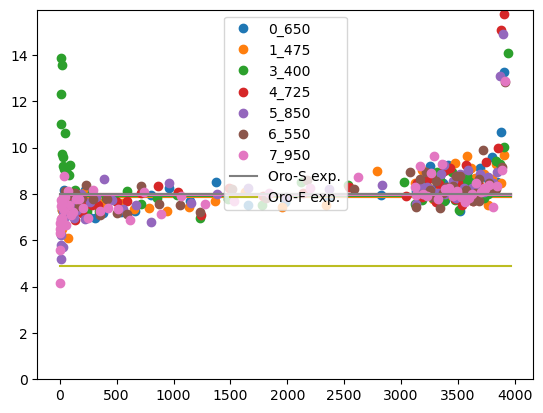

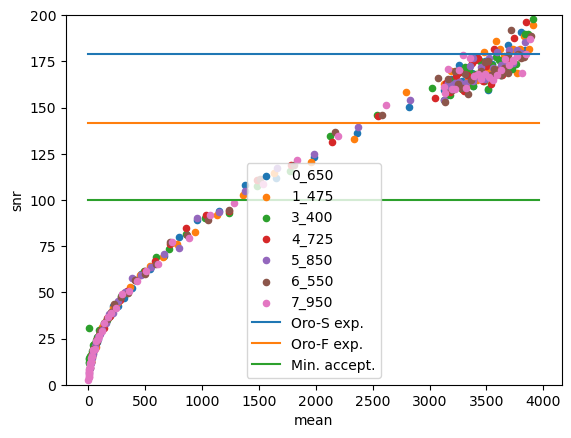

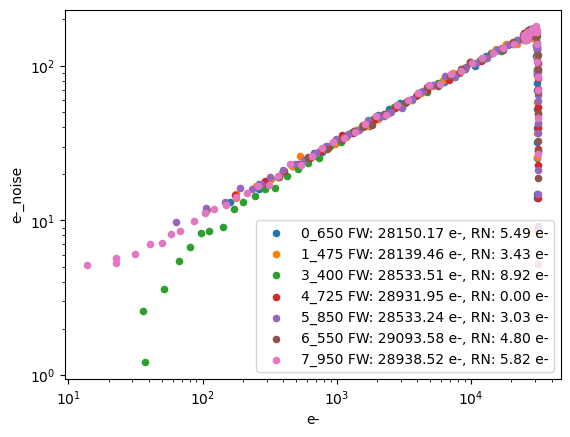

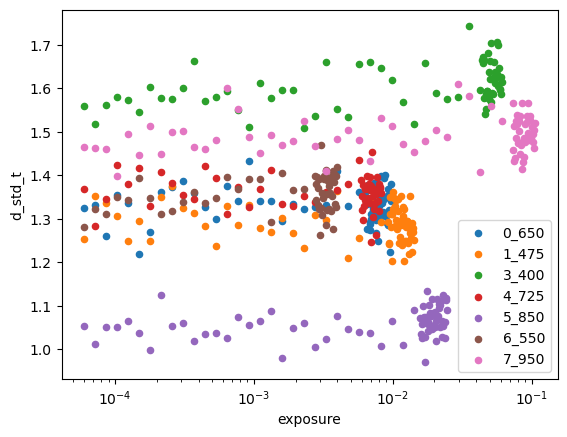

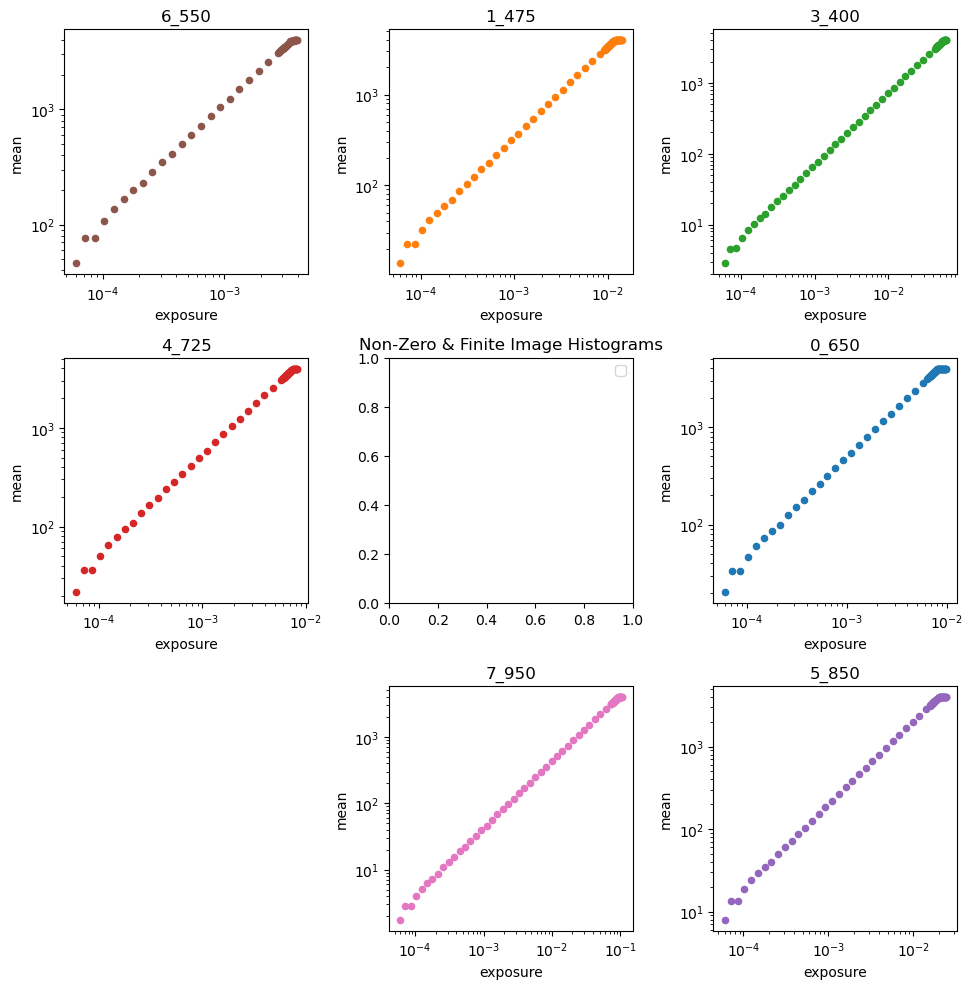

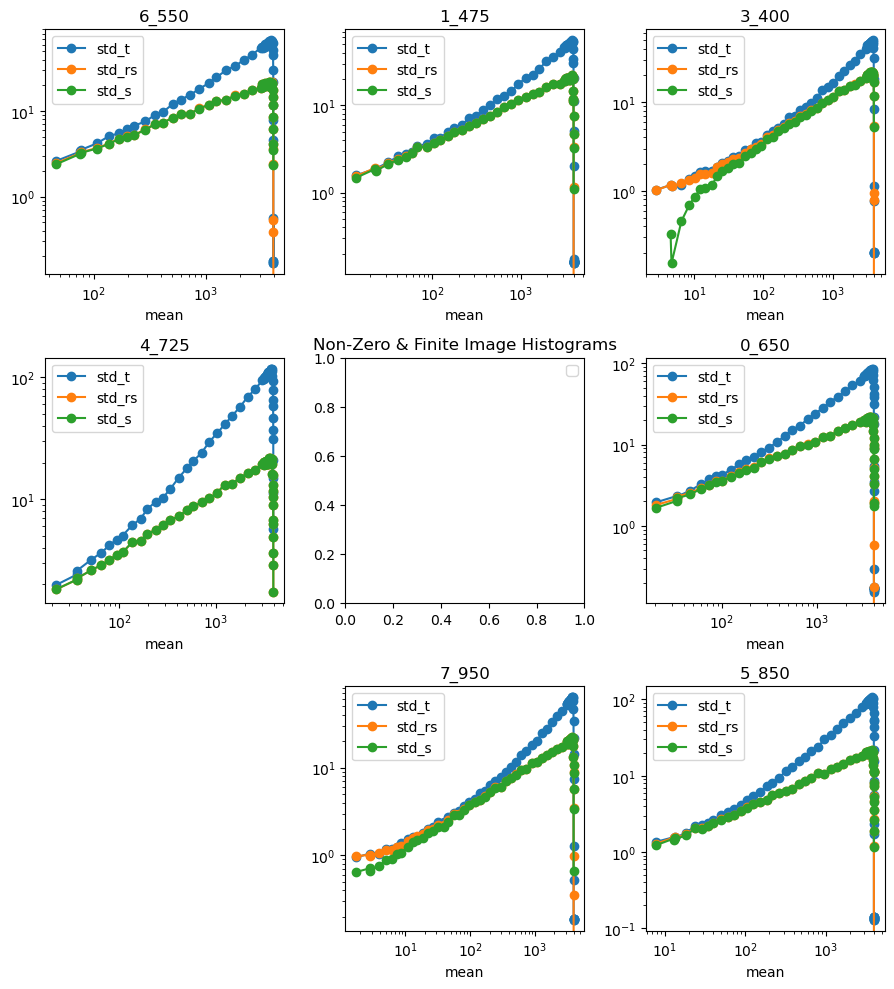

In [7]:
subject = 'SCT99'
process_ptc(subject)

--------------------------------------------
Processing SCT5/0_650
Loaded images (650_1025us_1_calibration) for: 0 (650 nm)
Loaded images (650_1025us_2_calibration) for: 0 (650 nm)
Loaded images (650_1025us_d_drk) for: 0 (650 nm)
Loaded images (650_11678us_1_calibration) for: 0 (650 nm)
Loaded images (650_11678us_2_calibration) for: 0 (650 nm)
Loaded images (650_11678us_d_drk) for: 0 (650 nm)
Loaded images (650_126934us_1_calibration) for: 0 (650 nm)
Loaded images (650_126934us_2_calibration) for: 0 (650 nm)
Loaded images (650_126934us_d_drk) for: 0 (650 nm)
Loaded images (650_128216us_1_calibration) for: 0 (650 nm)
Loaded images (650_128216us_2_calibration) for: 0 (650 nm)
Loaded images (650_128216us_d_drk) for: 0 (650 nm)
Loaded images (650_129511us_1_calibration) for: 0 (650 nm)
Loaded images (650_129511us_2_calibration) for: 0 (650 nm)
Loaded images (650_129511us_d_drk) for: 0 (650 nm)
Loaded images (650_130819us_1_calibration) for: 0 (650 nm)
Loaded images (650_130819us_2_calibrat

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Loaded images (475_135us_d_drk) for: 1 (475 nm)
Loaded images (475_1538us_1_calibration) for: 1 (475 nm)
Loaded images (475_1538us_2_calibration) for: 1 (475 nm)
Loaded images (475_1538us_d_drk) for: 1 (475 nm)
Loaded images (475_17516us_1_calibration) for: 1 (475 nm)
Loaded images (475_17516us_2_calibration) for: 1 (475 nm)
Loaded images (475_17516us_d_drk) for: 1 (475 nm)
Loaded images (475_199523us_1_calibration) for: 1 (475 nm)
Loaded images (475_199523us_2_calibration) for: 1 (475 nm)
Loaded images (475_199523us_d_drk) for: 1 (475 nm)
Loaded images (475_202236us_1_calibration) for: 1 (475 nm)
Loaded images (475_202236us_2_calibration) for: 1 (475 nm)
Loaded images (475_202236us_d_drk) for: 1 (475 nm)
Loaded images (475_203us_1_calibration) for: 1 (475 nm)
Loaded images (475_203us_2_calibration) for: 1 (475 nm)
Loaded images (475_203us_d_drk) for: 1 (475 nm)
Loaded images (475_204278us_1_calibration) for: 1 (475 nm)
Loaded images (475_204278us_2_calibration) for: 1 (475 nm)
Loaded 

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/minic

Loaded images (400_1538us_d_drk) for: 3 (400 nm)
Loaded images (400_17516us_1_calibration) for: 3 (400 nm)
Loaded images (400_17516us_2_calibration) for: 3 (400 nm)
Loaded images (400_17516us_d_drk) for: 3 (400 nm)
Loaded images (400_199523us_1_calibration) for: 3 (400 nm)
Loaded images (400_199523us_2_calibration) for: 3 (400 nm)
Loaded images (400_199523us_d_drk) for: 3 (400 nm)
Loaded images (400_203us_1_calibration) for: 3 (400 nm)
Loaded images (400_203us_2_calibration) for: 3 (400 nm)
Loaded images (400_203us_d_drk) for: 3 (400 nm)
Loaded images (400_2307us_1_calibration) for: 3 (400 nm)
Loaded images (400_2307us_2_calibration) for: 3 (400 nm)
Loaded images (400_2307us_d_drk) for: 3 (400 nm)
Loaded images (400_26275us_1_calibration) for: 3 (400 nm)
Loaded images (400_26275us_2_calibration) for: 3 (400 nm)
Loaded images (400_26275us_d_drk) for: 3 (400 nm)
Loaded images (400_299285us_1_calibration) for: 3 (400 nm)
Loaded images (400_299285us_2_calibration) for: 3 (400 nm)
Loaded im

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: Ma

Loaded images (725_88677us_1_calibration) for: 4 (725 nm)
Loaded images (725_88677us_2_calibration) for: 4 (725 nm)
Loaded images (725_88677us_d_drk) for: 4 (725 nm)
Loaded images (725_90us_1_calibration) for: 4 (725 nm)
Loaded images (725_90us_2_calibration) for: 4 (725 nm)
Loaded images (725_90us_d_drk) for: 4 (725 nm)
--------------------------------------------
--------------------------------------------
Processing SCT5/5_850
Loaded images (850_1025us_1_calibration) for: 5 (850 nm)
Loaded images (850_1025us_2_calibration) for: 5 (850 nm)
Loaded images (850_1025us_d_drk) for: 5 (850 nm)
Loaded images (850_11678us_1_calibration) for: 5 (850 nm)
Loaded images (850_11678us_2_calibration) for: 5 (850 nm)
Loaded images (850_11678us_d_drk) for: 5 (850 nm)
Loaded images (850_133016us_1_calibration) for: 5 (850 nm)
Loaded images (850_133016us_2_calibration) for: 5 (850 nm)
Loaded images (850_133016us_d_drk) for: 5 (850 nm)
Loaded images (850_135us_1_calibration) for: 5 (850 nm)
Loaded imag

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: Ma

--------------------------------------------
--------------------------------------------
Processing SCT5/6_550
Loaded images (550_1025us_1_calibration) for: 6 (550 nm)
Loaded images (550_1025us_2_calibration) for: 6 (550 nm)
Loaded images (550_1025us_d_drk) for: 6 (550 nm)
Loaded images (550_11678us_1_calibration) for: 6 (550 nm)
Loaded images (550_11678us_2_calibration) for: 6 (550 nm)
Loaded images (550_11678us_d_drk) for: 6 (550 nm)
Loaded images (550_135us_1_calibration) for: 6 (550 nm)
Loaded images (550_135us_2_calibration) for: 6 (550 nm)
Loaded images (550_135us_d_drk) for: 6 (550 nm)
Loaded images (550_1538us_1_calibration) for: 6 (550 nm)
Loaded images (550_1538us_2_calibration) for: 6 (550 nm)
Loaded images (550_1538us_d_drk) for: 6 (550 nm)
Loaded images (550_17516us_1_calibration) for: 6 (550 nm)
Loaded images (550_17516us_2_calibration) for: 6 (550 nm)
Loaded images (550_17516us_d_drk) for: 6 (550 nm)
Loaded images (550_203us_1_calibration) for: 6 (550 nm)
Loaded images 

/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
/opt/homebrew/Caskroom/miniconda/base/envs/orochi_sim_ctrl/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: Ma

              channel     k_adc     full_well  read_noise         DR
0  ../data/SCT5/0_650  7.698557  27018.575159    3.563742  77.595124
1  ../data/SCT5/1_475  7.575833  26390.122269    6.711478  71.892465
2  ../data/SCT5/3_400  7.491112   6071.320302    5.949783  60.175640
3  ../data/SCT5/4_725  7.676237  27242.562835    3.276526  78.396687
4  ../data/SCT5/5_850  7.569181  26674.085765    7.822968  70.654360
5  ../data/SCT5/6_550  8.089067  28065.485151    9.679809  69.246115
6  ../data/SCT5/7_950  7.954415  31529.443012    8.772675  71.111686


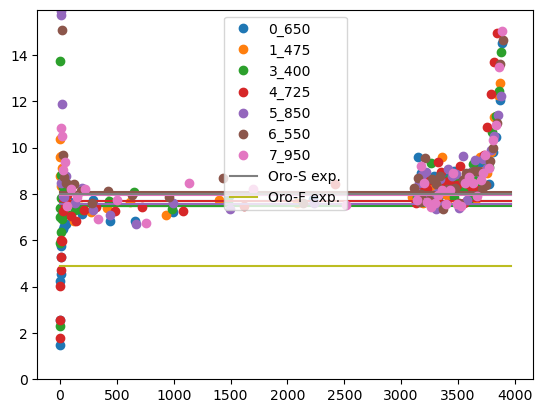

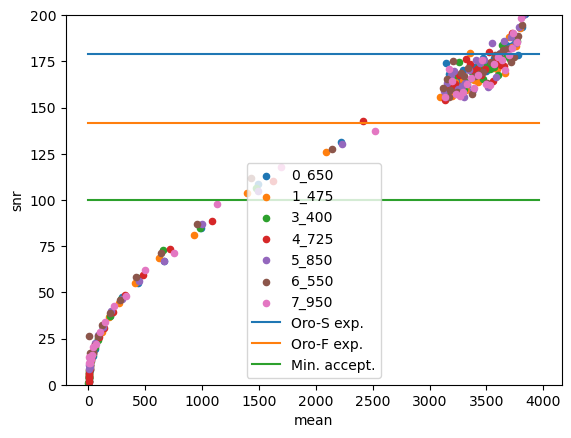

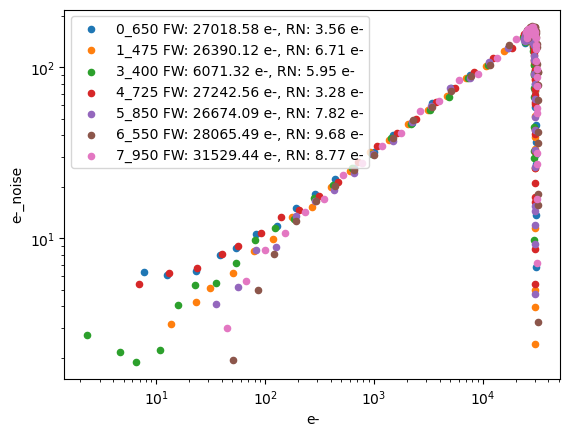

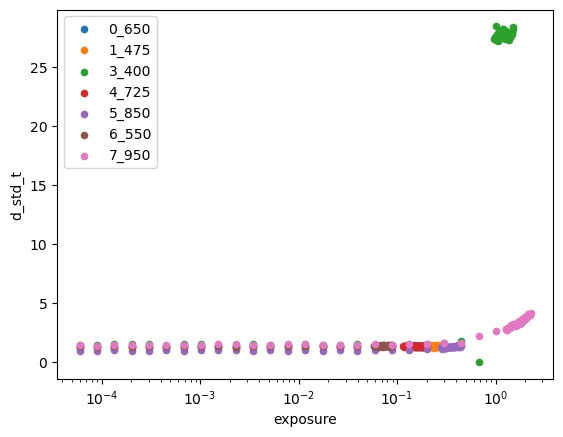

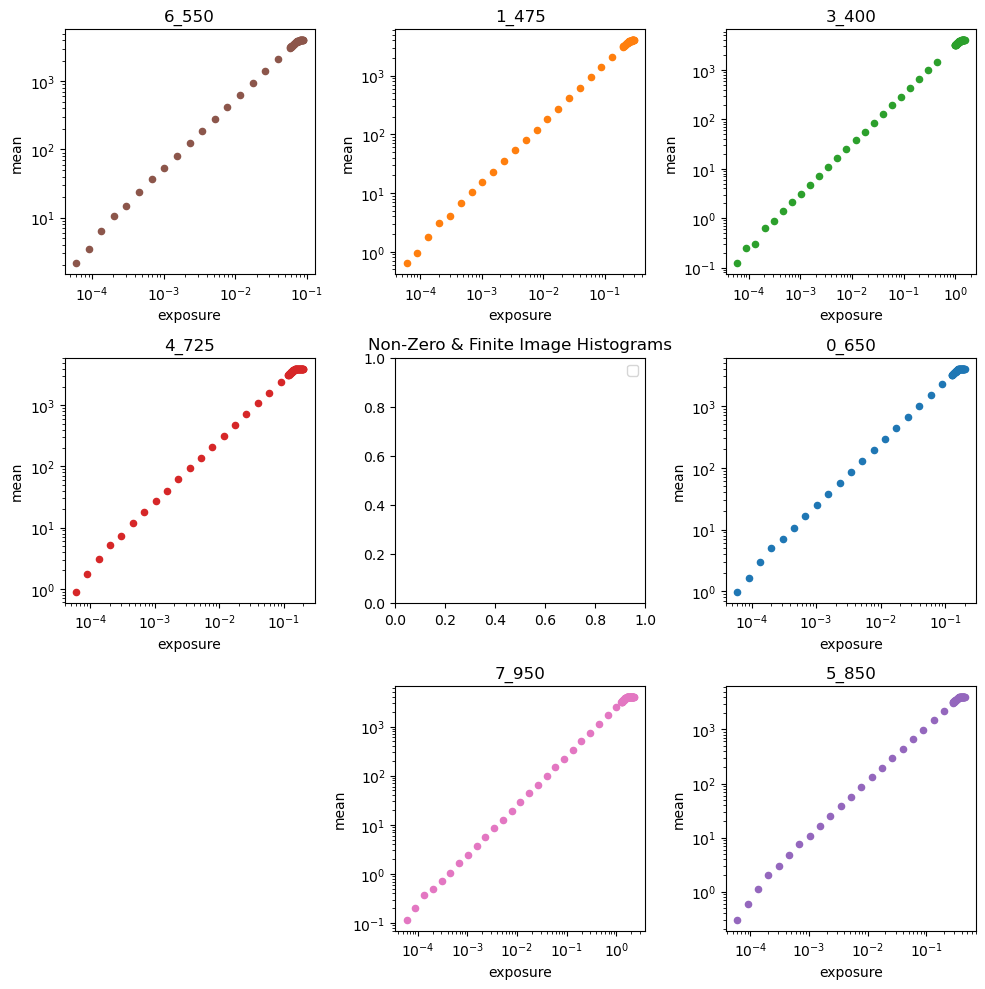

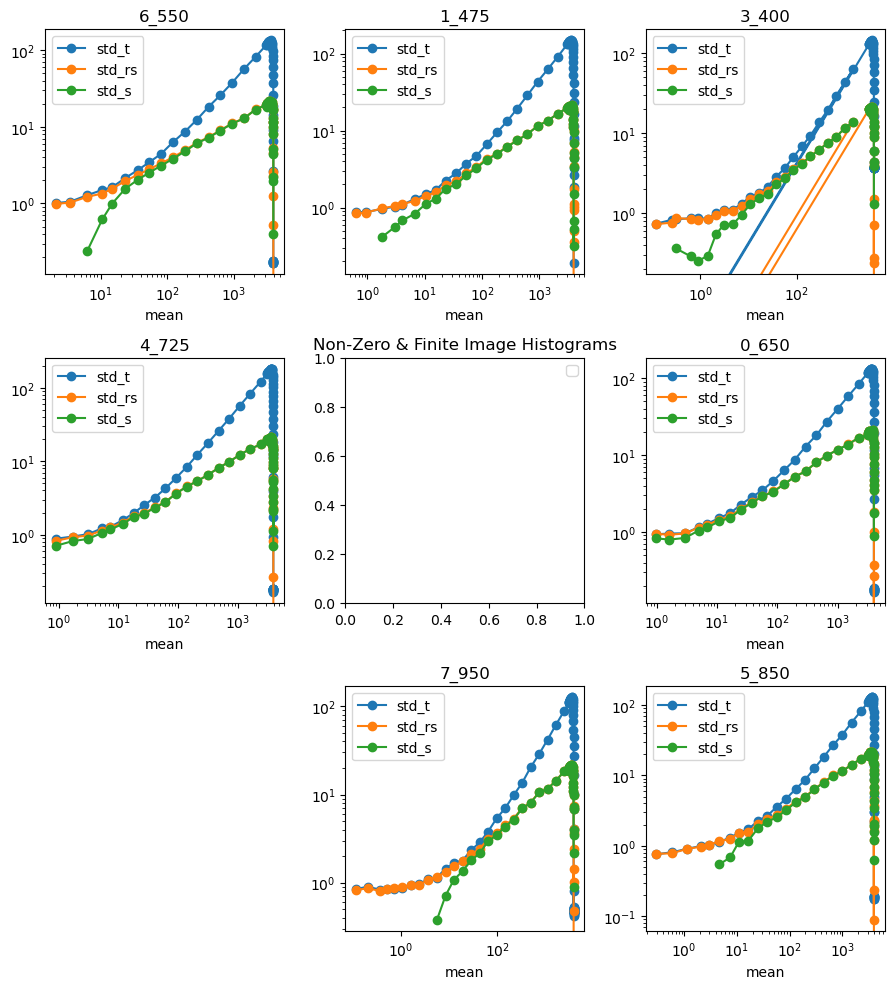

In [8]:
subject = 'SCT5'
process_ptc(subject)

Now we have this information, we need to properly compare it to the expectations of the OROCHI instrument, and scale accordingly.


First, we see that linearity is good over the 10 - 90 % response range - so we should keep the bias set as it is, and ensure that images are captured within this range.

Then, we need to make sure maximum SNR matches that of OROCHI, that we can achieve by limiting the electron count to the OROCHI Full Well, at 20000 e-.
This is approximately 2/3s of the detector response, ~2800 DN (12-bit mode).

But we also see from our SNR plots that the minimum SNR that we require occurs at ~2000 DN.

So this means we are aiming for an exposed region of ~2000 - 2800 DN, within the 12-bit window. This may be hard to achieve, if the dynamic range of the environment is much greater than this.
The best algorithm I think for achieving this is still the percentile algorithm, bbut greater guidance may be required to inform the number of pixels allowed to over expose. Or, we may need to do repeat imaging for the different targets, at different exposures.

SO what we need to do is allow for Auto-Exposure manual ROI selection.
- perform autoexposure on whole image / sample ROI
- select reference points
- re-run autoexposure on reference points
- set exposure for experiment
- repeat for a new reference point, and save etc.

# Notes

Likely that my Full Well record is an underestimate, due to exaggerated bias.

Note that Bauer set the bias to 39, whereas I have it set to 128. Remiedying this for future studies - recommend setting to 39 - but why?